In [1]:
import numpy as np
import random
from pynq import Overlay
from pynq import Clocks
import axitimer
max_fft_N = 12 # Logic and DMA max for simple mode on ARM32 is 4096 complex 32-bit elements
path = '/home/xilinx/jupyter_notebooks/fft_masters/thesis_test.bit'
ol = Overlay(path)
#print(ol.ip_dict.keys())

/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/ps.py:434: UserWarning: Setting frequency to the closest possible value 98.8879MHz.
  warnings.warn(


In [2]:
def bits_to_bytes(bit_str, base=2, byteorder='big') :
    nbytes = int(len(bit_str) * .125 + .9) if base == 2 else int(len(bit_str) * .5 + .9) if base == 16 else 0  
    return int(bit_str, base=base).to_bytes(nbytes, byteorder=byteorder)

def bytes_to_uint32s(byte_s) :
    assert type(byte_s) == bytes, RuntimeError
    return [int.from_bytes(byte_s[i:i+4], byteorder='big') for i in range(0,len(byte_s),4)]
#for Xilinx FFT
def create_config_tdata(N, fwd_inv=True):
    assert N > 2 and N < 13, RuntimeError
    N = int(N)
    NFFT = N.to_bytes(1, byteorder='big')            # Must be padded to byte
    CP_LEN = ''                                      # padded but unused for this FFT config
    FWD_INV = '0b1' if fwd_inv == True else '0b0'    # No padding
    SCALE_SCH = ''                                   # padded but unused for this FFT config
    return bytes_to_uint32s(bits_to_bytes(FWD_INV) + NFFT) # Final result needs padded to 8 bits worth and converted into 32-bit words for AXI

In [3]:
#for Xilinx FFT
"""
from axififo import FifoStreamDriver
ol = Overlay(path, download=False)
cfg_data = create_config_tdata(max_fft_N, True)
fft_cfg = ol.axi_fifo_mm_s_0
fft_cfg.send_tx_pkt(cfg_data)
#ol.axi_dma_0.register_map
#ol.ip_dict
#ol?
"""

'\nfrom axififo import FifoStreamDriver\nol = Overlay(path, download=False)\ncfg_data = create_config_tdata(max_fft_N, True)\nfft_cfg = ol.axi_fifo_mm_s_0\nfft_cfg.send_tx_pkt(cfg_data)\n#ol.axi_dma_0.register_map\n#ol.ip_dict\n#ol?\n'

In [5]:
import matplotlib.pyplot as plt
file_path = '/home/xilinx/jupyter_notebooks/fft_masters/REFERENCE.txt'
with open(file_path, 'r') as file:
    data = [float(line.strip()) for line in file if line.strip()]
    #print(data)
    adc_arr = np.array(data)
    print(adc_arr)

[ 167.  109.  -58. ... -224.  -94.  157.]


In [6]:
import time
from pynq import MMIO

fft_ip_address = ol.ip_dict['FFT_IP_0']['phys_addr']
print(hex(fft_ip_address))

RANGE = 65535
fft_ip = MMIO(fft_ip_address,RANGE)

axi_bram_address_IN = 0xA006_0000
mem_size = 32768
mmio_in = MMIO(axi_bram_address_IN,mem_size)

axi_bram_address_OUT = 0xA800_0000
mem_size = 512
mmio_out = MMIO(axi_bram_address_OUT,mem_size)

0xa0040000


In [7]:
address_offset = 0
length = 8192
import struct
def binary(num):
    return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))
for x in range(int(length)):
    
   #y_bin = binary(y[x])
    y_bin = binary(adc_arr[x])
    data = bits_to_bytes(y_bin)
    data = data[::-1] #reverse bytes order bc python is stupid
    
    mmio_in.write(address_offset,data)
    address_offset = address_offset + 4

#for x in range(L):
#    result = mmio_in.read(x*4)
#    print('location ' + str(x) + ': ' + hex(result))
    

In [8]:
for x in range(length):
    result = mmio_in.read(x*4)
    print('location ' + str(x) + ': ' + hex(result))
    #floats[x] = extract_hex_values_as_bytes(hex(result))

location 0: 0x43270000
location 1: 0x42da0000
location 2: 0xc2680000
location 3: 0xc28a0000
location 4: 0xc2540000
location 5: 0xc2580000
location 6: 0x41d80000
location 7: 0x43100000
location 8: 0x43040000
location 9: 0x43610000
location 10: 0x43570000
location 11: 0x433c0000
location 12: 0x43908000
location 13: 0x43920000
location 14: 0x43400000
location 15: 0x42380000
location 16: 0x42700000
location 17: 0x42440000
location 18: 0x428e0000
location 19: 0x42c00000
location 20: 0x42340000
location 21: 0x42200000
location 22: 0x40800000
location 23: 0xc30a0000
location 24: 0xc30e0000
location 25: 0xc2080000
location 26: 0x41c00000
location 27: 0x40000000
location 28: 0x42880000
location 29: 0x42640000
location 30: 0x41100000
location 31: 0xc2500000
location 32: 0xc2e40000
location 33: 0xc3180000
location 34: 0xc34b0000
location 35: 0xc36a0000
location 36: 0xc3270000
location 37: 0xc3130000
location 38: 0xc3200000
location 39: 0xc3780000
location 40: 0xc3a60000
location 41: 0xc3bc0000
lo

location 6209: 0x447d8000
location 6210: 0x443c0000
location 6211: 0x43d50000
location 6212: 0x43958000
location 6213: 0x43740000
location 6214: 0x43640000
location 6215: 0x43260000
location 6216: 0xc0a00000
location 6217: 0xc2f20000
location 6218: 0xc32f0000
location 6219: 0xc3b00000
location 6220: 0xc40f8000
location 6221: 0xc41c8000
location 6222: 0xc4128000
location 6223: 0xc41f4000
location 6224: 0xc4424000
location 6225: 0xc44c4000
location 6226: 0xc4590000
location 6227: 0xc4478000
location 6228: 0xc4398000
location 6229: 0xc439c000
location 6230: 0xc41c0000
location 6231: 0xc4024000
location 6232: 0xc4054000
location 6233: 0xc4028000
location 6234: 0xc3aa8000
location 6235: 0xc3820000
location 6236: 0xc3480000
location 6237: 0xc2240000
location 6238: 0x42e60000
location 6239: 0x43a48000
location 6240: 0x43fd8000
location 6241: 0x43bc8000
location 6242: 0x43650000
location 6243: 0x43878000
location 6244: 0x43a88000
location 6245: 0x43d10000
location 6246: 0x440bc000
location 624

In [9]:

fft_ip = ol.FFT_IP_0
tmr = ol.axi_timer_0


tmr.start_tmr()
start = tmr.read_count()

fft_ip.write(0x00, 0x01)


while True:
    status = fft_ip.read(0x00)
    if status & 0x2:  # ap_done bit
        break

end = tmr.read_count()

hw_time = tmr.time_it(start, end)

print(f"Hardware FFT execution time: {hw_time * 1000:.3f} ms")

Hardware FFT execution time: 17.308 ms


In [12]:
fft_ip_axi = ol.FFT_IP_0
fft_ip_axi.write(0x00, 0x01)
while True:
    status = fft_ip.read(0x00)  # Read the CTRL register
    if status & 0x02:  # 'ap_done' is the second bit (bit 1)
        print("FFT Done")
        break
    time.sleep(0.1)

FFT Done


In [10]:
ol.ip_dict.keys()

dict_keys(['AXI_peak_finder_final_0', 'axi_intc_0', 'axi_timer_0', 'FFT_IP_0', 'zynq_ultra_ps_e_0'])

In [16]:
peak = ol.AXI_peak_finder_final_0
peak.write(0x00, 0x46a73000)
#peak.write(0x04, 0x1)

In [15]:
peak.write(0x04, 0x1)

In [13]:
peak.read(0x08)

0

In [14]:
hex(peak.mmio.base_addr)

'0xa0000000'

In [17]:
bram = ol.axi_bram_ctrl_1  # or whatever it's named
bram.read(0x00)  # read output data

0

In [13]:
def extract_hex_values_as_bytes(line):
    if line.startswith("0x"):
        hex_str = line[2:]  #remove 0x
        try:
            byte_value = bytes.fromhex(hex_str)  #convert to bytes
            float_value = struct.unpack('!f', byte_value)[0]  #convert to float
            return float_value
        except ValueError:
            return 0 
        except struct.error:
            print(f"Invalid byte length for float conversion: {line}")
        
    return None


In [28]:
floats = np.zeros(L, dtype=np.float32)
for x in range(8192):
    result = mmio_in.read(x*4)
    #print(hex(result))
    #print('location ' + hex(x*4) + ', ' + str(x) +': ' + hex(result))
    floats[x] = extract_hex_values_as_bytes(hex(result))
    print(floats[x])

40479.0
5061.7773
27871.756
43212.324
58078.35
15960.414
83328.91
30582.328
79530.78
37073.53
13294.86
16587.982
37710.64
27344.643
55462.867
17274.445
28891.309
57717.695
44571.824
41066.57
50633.3
48708.383
55099.09
38287.453
65076.098
95036.84
34394.28
20539.172
36574.47
129258.34
21602.752
12350.75
24468.086
135900.14
49642.953
36075.203
9436.165
108427.99
4850.8027
31505.723
51371.242
149679.78
63942.277
63510.78
37748.176
184150.95
28775.682
41120.895
31774.672
157949.1
31945.541
34306.664
42638.695
224483.14
27496.7
50071.797
45521.793
193649.05
130746.65
117396.09
62457.97
203614.56
175817.47
109552.91
101008.664
166371.12
204177.98
67669.914
76681.84
177957.64
241003.94
135744.83
68313.58
127146.38
316009.38
115560.32
73224.81
98072.54
414430.16
57351.625
24904.03
47973.973
461811.62
40345.043
71358.3
12110.731
475188.78
32503.818
94265.18
83749.664
493960.28
80582.766
127983.125
86650.16
471942.12
159804.88
138013.44
139075.72
526913.44
257967.72
192166.72
132109.05
443008.28

870.5108
592.8139
1133.6951
259.1117
1556.2968
1723.1132
1779.8458
1027.1808
1773.5616
1379.1238
139.32674
954.37494
2157.0757
2717.3296
2736.6204
990.6245
949.7712
2575.223
448.3817
2018.5864
720.748
1065.0728
74.420265
2108.4194
1729.0574
3579.8752
1441.0171
1189.3572
1354.7856
889.03503
2983.9004
1675.2174
1029.9517
1480.2301
1612.1779
1047.026
1028.09
2433.573
1440.8876
1419.4377
660.9217
696.4935
993.59033
1733.6888
1844.0247
1615.0724
2310.5393
808.9649
2551.9846
497.4572
965.2272
1602.9384
2922.6653
563.51514
3442.8582
2146.5923
1839.9808
1857.984
715.0721
846.1887
210.63173
709.73035
3357.795
408.37918
1240.741
755.1281
2364.8474
631.3901
2340.7917
2060.7622
2516.2546
2283.2239
1102.3807
1463.1302
1491.0592
589.9674
1635.5426
498.99213
2554.1206
494.35324
1614.2456
1856.9949
918.8042
512.05023
1770.8147
916.5816
1418.5415
1018.6101
3515.4211
1992.0983
977.24945
286.94568
2142.2737
582.3302
1249.6094
914.12756
634.46027
2047.6035
1531.8965
247.16437
797.8278
1869.7136
686.30066


32503.965
475184.6
12110.376
71358.266
40344.973
461806.38
47973.434
24904.434
57351.23
414426.6
98071.7
73224.72
115558.414
316005.97
127145.22
68313.266
135742.3
241000.67
177955.1
76681.03
67668.0
204174.83
166368.2
101007.88
109553.52
175816.72
203614.02
62457.96
117395.91
130745.57
193648.08
45521.727
50071.62
27496.1
224481.5
42638.47
34306.707
31944.395
157947.7
31774.613
41120.535
28774.916
184149.45
37747.383
63510.082
63942.19
149678.31
51370.656
31505.57
4850.2437
108426.55
9435.737
36074.875
49642.67
135897.89
24467.74
12350.534
21602.396
129257.14
36574.168
20539.2
34394.28
95035.96
65075.145
38287.06
55098.86
48707.863
50632.29
41066.223
44571.465
57716.766
28890.922
17274.398
55462.688
27343.783
37710.004
16588.133
13294.988
37073.02
79529.055
30582.014
83327.91
15959.538
58077.062
43211.215
27871.152
5062.598


In [23]:
floats = np.zeros(L, dtype=np.float32)
for x in range(8192):
    result = mmio_in.read(x*4)
    #print(hex(result))
    #print('location ' + hex(x*4) + ', ' + str(x) +': ' + hex(result))
    #floats[x] = extract_hex_values_as_bytes(hex(result))
    print(floats[x])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


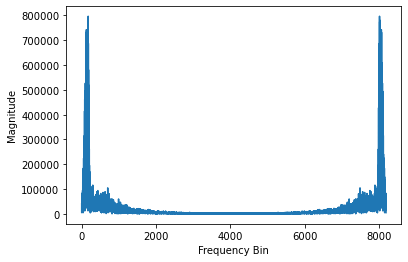

In [29]:
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot(floats)
ax.set_xlabel('Frequency Bin')
ax.set_ylabel('Magnitude');

In [ ]:
ol.ip_dict

In [13]:
ol.axi_dma_1?

In [14]:
dma = ol.axi_dma_1
dma_send = ol.axi_dma_1.sendchannel
dma_recv = ol.axi_dma_1.recvchannel

In [15]:
dma.register_map

RegisterMap {
  MM2S_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  MM2S_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SGDecErr=0, IOC_Irq=0, Dly_Irq=0, Err_Irq=0, IRQThresholdSts=0, IRQDelaySts=0),
  MM2S_CURDESC = Register(Current_Descriptor_Pointer=0),
  MM2S_CURDESC_MSB = Register(Current_Descriptor_Pointer=0),
  MM2S_TAILDESC = Register(Tail_Descriptor_Pointer=0),
  MM2S_TAILDESC_MSB = Register(Tail_Descriptor_Pointer=0),
  MM2S_SA = Register(Source_Address=0),
  MM2S_SA_MSB = Register(Source_Address=0),
  MM2S_LENGTH = Register(Length=0),
  SG_CTL = Register(SG_CACHE=0, SG_USER=0),
  S2MM_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  S2MM_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SG

In [16]:
from pynq import allocate
input_buffer = allocate(shape=(1,), dtype=np.uint32)

input_buffer[0] = 0x46a73000 #threshold 21400 in bytes